In [1]:
import imageio
import matplotlib.pyplot as plt
from argoverse.utils.se3 import SE3
import cv2
import numpy as np
import scipy.ndimage
import argoverse 
from argoverse.utils.se3 import SE3
from argoverse.data_loading.simple_track_dataloader import SimpleArgoverseTrackingDataLoader
from argoverse.utils.calibration import get_calibration_config
from PIL import Image

import os
from tqdm import tqdm
%matplotlib inline


In [2]:
def homography_from_calibration(camera_SE3_ground: SE3, K: np.ndarray) -> np.ndarray:
    """
    See Hartley Zisserman, Section 8.1.1
    """
    r1 = camera_SE3_ground.transform_matrix[:3,0].reshape(-1,1)
    r2 = camera_SE3_ground.transform_matrix[:3,1].reshape(-1,1)
    t =  camera_SE3_ground.transform_matrix[:3,3].reshape(-1,1)
    
    img_H_ground = K.dot(np.hstack([r1,r2,t]))
    return img_H_ground

def resize_mask(mask):
    # transform the mask to make it align with labels
    image = scipy.ndimage.rotate(cv2.resize(mask, (196, 200)), angle = 270)

    M = np.float32([[1,0,0], [0,1,-25]])
    image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    image = image[:-25, :]
    image = cv2.copyMakeBorder(image, 0, 25, 0, 0, cv2.BORDER_REPLICATE)
    return image



In [3]:
# Set up path to data
ARGOVERSE_DATA_ROOT = './data/argo/argoverse-tracking/'
split = 'val'
data_root_split = os.path.join(ARGOVERSE_DATA_ROOT, split)
# log_id = '10b8dee6-778f-33e4-a946-d842d2d9c3d7'
log_id = '5ab2697b-6e3e-3454-a36a-aba2c6f27818'
camera_name = 'ring_front_center'
# cam_timestamp = '315968229010581848'

MASK_ROOT = './data/argo/masks'
mask_folder = os.path.join(MASK_ROOT, split, log_id, camera_name)
# out_folder = os.path.join('./data/argo/masks_warped', split, log_id, camera_name)
# if not os.path.exists(out_folder):
#     os.makedirs(out_folder)

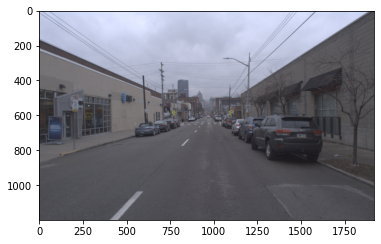

In [4]:
img_folder = os.path.join(ARGOVERSE_DATA_ROOT, split, log_id, camera_name)
img_names = sorted(os.listdir(img_folder))
img_name = img_names[0]
img = Image.open(os.path.join(img_folder, img_name))
plt.imshow(img)


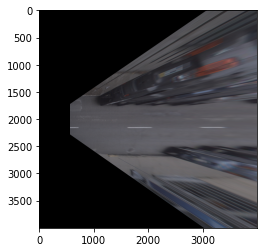

In [9]:
cam_timestamp = img_name.split('.')[0].split('_')[-1]
dl = SimpleArgoverseTrackingDataLoader(data_dir=data_root_split, labels_dir=data_root_split)
city = dl.get_city_name(log_id)
city_SE3_egovehicle = dl.get_city_to_egovehicle_se3(log_id, cam_timestamp)
calib_data = dl.get_log_calibration_data(log_id)
camera_config = get_calibration_config(calib_data, camera_name)

camera_SE3_egovehicle = camera_config.extrinsic
camera_R_egovehicle = camera_SE3_egovehicle[:3,:3]
camera_t_egovehicle = camera_SE3_egovehicle[:3,3]
camera_SE3_egovehicle = SE3(rotation=camera_R_egovehicle, translation=camera_t_egovehicle)
# Extract 3x3 intrinsics matrix
K = camera_config.intrinsic[:,:3]
AXLE_HEIGHT_FROM_GROUND = 0.33 # in meters, 
ground_SE3_egovehicle = SE3(rotation=np.eye(3), translation=np.array([0,0,AXLE_HEIGHT_FROM_GROUND]))
egovehicle_SE3_ground = ground_SE3_egovehicle.inverse()
camera_SE3_ground = camera_SE3_egovehicle.right_multiply_with_se3(egovehicle_SE3_ground)
img_H_ground = homography_from_calibration(camera_SE3_ground, K)
ground_H_img = np.linalg.inv(img_H_ground)

LATERAL_EXTENT = 20 # look 20 meters left and right
FORWARD_EXTENT = 40 # look 40 meters ahead

resolution = 0.01 # in meters/px
out_width = int(FORWARD_EXTENT / resolution)
out_height = int(LATERAL_EXTENT*2 / resolution)

RESCALING = int(1/resolution) # pixels/meter, if rescaling=1, then 1 px/1 meter
SHIFT = int(out_width//2)
shiftedground_H_ground = np.array(
    [
        [RESCALING,0,0],
        [0,RESCALING,SHIFT],
        [0,0,1]
    ])
shiftedground_H_img = shiftedground_H_ground.dot(ground_H_img)

# warping the mask
img_np = np.array(img)
bev_np = cv2.warpPerspective(img_np, shiftedground_H_img, dsize=(out_width, out_height))
plt.imshow(bev_np)

In [19]:
def resize_mask(mask):
    # transform the mask to make it align with labels
    image = scipy.ndimage.rotate(cv2.resize(mask, (196, 200)), angle = 270)

    M = np.float32([[1,0,0], [0,1,-25]])
    image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    image = image[:-25, :]
    image = cv2.copyMakeBorder(image, 0, 25, 0, 0, cv2.BORDER_REPLICATE)
    return image

def resize_mask_small(mask):
    # transform the mask to make it align with labels
    image = scipy.ndimage.rotate(cv2.resize(mask, (98, 100)), angle = 270)

    M = np.float32([[1,0,0], [0,1,-13]])
    image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    image = image[:-13, :]
    image = cv2.copyMakeBorder(image, 0, 13, 0, 0, cv2.BORDER_REPLICATE)
    print(image.shape)
    return image


(98, 100, 3)


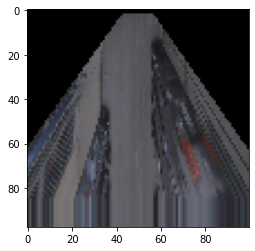

In [20]:
resized_img = resize_mask_small(bev_np)
plt.imshow(resized_img)

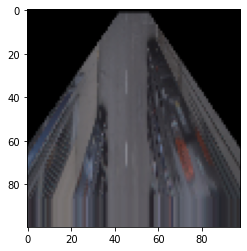

In [21]:
resized_img = resize_mask(bev_np)
resized_img = cv2.resize(resized_img, (98, 100))
plt.imshow(resized_img)